In [1]:
import numpy as np
import matplotlib.pyplot as plt
import time
import random
import os

# Learn SDE driven by fBM
In this notebook, we demonstrate how to use Logsig-RNN to learn SDE driven by fractional Brownian motion. We consider SDE satisfying the following equation:
$$
dY_t = (-\pi Y_t + \sin(\pi t))dX^{(1)}_t + Y_t dX^{(2)}_t, Y_{0} = 0,
$$
where $X_t = (X^{(1)}_t, X^{(2)}_t) = (t, W^H_t)$, $W^H_{t}$ is a $1$-d fractional Brownian motion with Hurst parameter $H$, and the integral is in the Stratonovich sense.

## Generate samples of SDE

In [2]:
from SDEdataSimulation import get_sde_paths

hurst = 0.75 #The Hurst parameter
data_prefix = 'data/fbm_%.2f/' % hurst # The directory to save the data
number_of_independent_simulations=2200 # Number of samples
total_no_steps=50001 # Number of time steps
maturity=10 # The maturity of SDE

if os.path.exists(data_prefix+'paths.npy'):
    BM_paths = np.load('data/fbm_%.2f/paths.npy' % hurst)
    output = np.load('data/fbm_%.2f/output.npy' % hurst)
else:
    BM_paths, output = get_sde_paths(hurst, data_prefix, number_of_independent_simulations, total_no_steps, maturity)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:10<00:00,  1.01s/it]


## Visualize the SDE

Text(0.5, 1.0, 'SDE driven by fBM with H = 0.75')

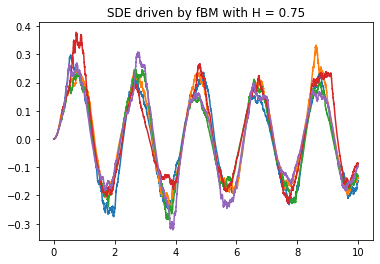

In [14]:
T = np.linspace(0,maturity,50001)
for i in range(5):
    plt.plot(T,output[i])
plt.title('SDE driven by fBM with H = %.2f'%hurst)

## Compute the logsignatures of samples

In [14]:
from FeatureSetCalculation_Lib import ComputeMultiLevelLogsig1dBM

deg_of_logsig = 5 # the degree of logsignature
number_of_segment = 8 # thej number of segments of the path

X_logsig = ComputeMultiLevelLogsig1dBM(
            BM_paths, number_of_segment, deg_of_logsig, maturity)

  0%|                                                                                 | 3/2200 [00:00<01:42, 21.48it/s]

start computing the logsigs of degree 5:


100%|██████████████████████████████████████████████████████████████████████████████| 2200/2200 [01:48<00:00, 20.28it/s]


## Learn the data using Logsig-RNN

In [27]:
from LSTM_Learning_Lib import Model

# hyperparameters
lr=0.001
training_iters=8000000
batch_size=64
display_step=100
n_hidden=64
n_classes=1
error_tol=0.001/512
test_len=200
n_input = np.shape(X_logsig)[2]
Y = output[:,-1]

prefix = 'results/fbm_%.2f/' % hurst
# build model
model3 = Model(lr, training_iters, batch_size, display_step, n_input,
                       number_of_segment, n_hidden, n_classes, deg_of_logsig, X_logsig, Y, prefix)

# train model
print('start training:')
fixed_error_result_model3 = model3.BuildModelKeras(test_len, error_tol)

start training:
Iter 100, Training Accuracy= 0.0010420
Iter 200, Training Accuracy= 0.0005747
Iter 300, Training Accuracy= 0.0002854
Iter 400, Training Accuracy= 0.0002453
Iter 500, Training Accuracy= 0.0001418
Iter 600, Training Accuracy= 0.0000503
Iter 700, Training Accuracy= 0.0000758
Iter 800, Training Accuracy= 0.0002714
Iter 900, Training Accuracy= 0.0000916
Iter 1000, Training Accuracy= 0.0000467
Iter 1100, Training Accuracy= 0.0000674
Iter 1200, Training Accuracy= 0.0000345
Iter 1300, Training Accuracy= 0.0000781
Iter 1400, Training Accuracy= 0.0000519
Iter 1500, Training Accuracy= 0.0000396
Iter 1600, Training Accuracy= 0.0000235
Iter 1700, Training Accuracy= 0.0000440
Iter 1800, Training Accuracy= 0.0000381
Iter 1900, Training Accuracy= 0.0000264
Iter 2000, Training Accuracy= 0.0000204
Iter 2100, Training Accuracy= 0.0000220
Iter 2200, Training Accuracy= 0.0000363
Iter 2300, Training Accuracy= 0.0000944
Iter 2400, Training Accuracy= 0.0000202
Iter 2500, Training Accuracy= 0.0

In [28]:
print('Test Loss is:',fixed_error_result_model3['Loss'])

Test Loss is: 1.3750724e-05


### Visualize the results

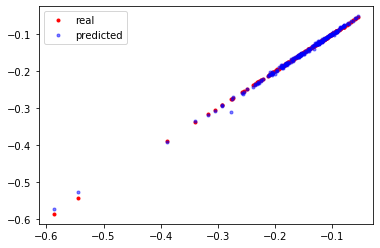

In [29]:
plt.plot(Y[-200:], Y[-200:], '.r', label='real')
plt.plot(Y[-200:], fixed_error_result_model3['Pred'],'.b',alpha=0.5, label='predicted')
plt.legend()